In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/shelter-animal-outcomes/sample_submission.csv.gz
/kaggle/input/shelter-animal-outcomes/train.csv.gz
/kaggle/input/shelter-animal-outcomes/test.csv.gz


# 1. 데이터 가져오기

In [2]:
train = pd.read_csv('/kaggle/input/shelter-animal-outcomes/train.csv.gz')
test = pd.read_csv('/kaggle/input/shelter-animal-outcomes/test.csv.gz')

In [3]:
all_data = pd.concat([train, test]).reset_index(drop=True)

In [4]:
all_data

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,NaN
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,NaN
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White,NaN
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,NaN
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,NaN
...,...,...,...,...,...,...,...,...,...,...,...
38180,NaN,NaN,2014-07-08 14:50:00,NaN,NaN,Cat,Neutered Male,2 months,Domestic Shorthair Mix,Black,11452.0
38181,NaN,NaN,2014-10-21 12:57:00,NaN,NaN,Cat,Intact Female,2 weeks,Domestic Shorthair Mix,Blue,11453.0
38182,NaN,NaN,2014-09-29 09:00:00,NaN,NaN,Cat,Intact Female,1 year,Domestic Shorthair Mix,Calico,11454.0
38183,NaN,Rambo,2015-09-05 17:16:00,NaN,NaN,Dog,Neutered Male,6 years,German Shepherd Mix,Black/Tan,11455.0


# 2. 메타데이터 전처리

## 날짜 데이터 처리하기

In [5]:
#날짜 처리는 all_data를 concat한 뒤에 바로 추가하는 게 좋음 
all_data['DateTime'] = all_data['DateTime'].astype('datetime64')
all_data['Year'] = all_data['DateTime'].dt.year
all_data['Month'] = all_data['DateTime'].dt.month
all_data['Day'] = all_data['DateTime'].dt.day 
all_data['Hour'] = all_data['DateTime'].dt.hour
all_data['Minute'] = all_data['DateTime'].dt.minute
all_data['Week'] = all_data['DateTime'].dt.week #공휴일도 영향을 줌 
all_data['DayOfWeek'] = all_data['DateTime'].dt.weekday

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


## AgeuponOutcome 단위 통일하기

In [6]:
def age(x): #날짜 단위 통일하는 함수 만들기
    
    if pd.isnull(x): #결측치 처리(결측치의 dtype이 float)
        return -1
    num = int(x.split()[0]) 
    
    if 'year' in x:
        return 365*num
    elif 'month' in x:
        return 30*num
    elif 'week' in x:
        return 7*num
    else:
        return num

In [7]:
all_data['AgeuponOutcome'] = all_data['AgeuponOutcome'].apply(age)

In [8]:
all_data.head(5)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID,Year,Month,Day,Hour,Minute,Week,DayOfWeek
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365,Shetland Sheepdog Mix,Brown/White,NaN,2014,2,12,18,22,7,2
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,NaN,2013,10,13,12,44,41,6
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,NaN,2015,1,31,12,28,5,5
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,NaN,2014,7,11,19,9,28,4
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730,Lhasa Apso/Miniature Poodle,Tan,NaN,2013,11,15,12,52,46,4


## Animal ID Numerical 성격을 살려주기

In [9]:
all_data['Name'] = all_data['Name'].notnull()

In [10]:
all_data['AnimalID'] = all_data['AnimalID'].apply(str)
all_data['AnimalID'] = all_data['AnimalID'].apply(lambda x: x[1:])

In [11]:
all_data

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,ID,Year,Month,Day,Hour,Minute,Week,DayOfWeek
0,671945,True,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365,Shetland Sheepdog Mix,Brown/White,NaN,2014,2,12,18,22,7,2
1,656520,True,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,NaN,2013,10,13,12,44,41,6
2,686464,True,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,NaN,2015,1,31,12,28,5,5
3,683430,False,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,NaN,2014,7,11,19,9,28,4
4,667013,False,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730,Lhasa Apso/Miniature Poodle,Tan,NaN,2013,11,15,12,52,46,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38180,an,False,2014-07-08 14:50:00,NaN,NaN,Cat,Neutered Male,60,Domestic Shorthair Mix,Black,11452.0,2014,7,8,14,50,28,1
38181,an,False,2014-10-21 12:57:00,NaN,NaN,Cat,Intact Female,14,Domestic Shorthair Mix,Blue,11453.0,2014,10,21,12,57,43,1
38182,an,False,2014-09-29 09:00:00,NaN,NaN,Cat,Intact Female,365,Domestic Shorthair Mix,Calico,11454.0,2014,9,29,9,0,40,0
38183,an,True,2015-09-05 17:16:00,NaN,NaN,Dog,Neutered Male,2190,German Shepherd Mix,Black/Tan,11455.0,2015,9,5,17,16,36,5


## 텍스트 데이터 vectorize 사용하기

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
breed_text = vectorizer.fit_transform(all_data['Breed']).toarray()

vectorizer = TfidfVectorizer()
color_text = vectorizer.fit_transform(all_data['Color']).toarray()

In [13]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=10) #n_components를 변경해가면서 적정한 차원을 설정 (for loop)
breed_svd = svd.fit_transform(breed_text)
breed_svd

array([[ 0.04707169,  0.02519452,  0.01397907, ...,  0.0040852 ,
         0.01683313, -0.00239646],
       [ 0.99449628, -0.04320528, -0.03968845, ...,  0.00402895,
         0.00409927,  0.0038728 ],
       [ 0.12788387,  0.9540275 , -0.26645196, ..., -0.0104377 ,
        -0.02392973,  0.01156172],
       ...,
       [ 0.99449628, -0.04320528, -0.03968845, ...,  0.00402895,
         0.00409927,  0.0038728 ],
       [ 0.09154683,  0.08398612,  0.11980008, ..., -0.23427194,
         0.01556323, -0.00299394],
       [ 0.0176188 ,  0.24462124,  0.88029373, ..., -0.02602332,
        -0.04033204,  0.00606593]])

In [14]:
svd = TruncatedSVD(n_components=10) 
color_svd = svd.fit_transform(color_text)
color_svd

array([[ 6.07995290e-01,  6.24923339e-01,  9.68841062e-02, ...,
        -2.51581846e-02, -3.57675948e-02, -8.01826554e-03],
       [ 8.40863293e-02,  2.46263012e-01, -8.33210458e-02, ...,
         2.68551692e-02, -2.20525878e-01,  5.43874858e-02],
       [ 3.25392176e-01,  1.44662812e-01,  5.00208553e-01, ...,
        -1.65717316e-02,  4.89062627e-02, -6.87068172e-03],
       ...,
       [ 1.04183003e-03,  4.64780511e-04,  1.86409305e-03, ...,
        -1.71180090e-03, -3.28151804e-03,  2.78156418e-02],
       [ 5.10892105e-01, -3.51989601e-01,  1.37841977e-01, ...,
         1.29733997e-02,  2.17619384e-02,  1.26020326e-03],
       [ 9.31152122e-03,  1.81503218e-02,  5.32993514e-03, ...,
         1.44612416e-02, -1.45677171e-01,  5.63264205e-02]])

In [15]:
df_breed = pd.DataFrame(breed_svd)
df_breed.columns = ['a','b','c','d','e','f','g','h','i','j']
df_breed

,a,b,c,d,e,f,g,h,i,j
0,0.047072,0.025195,0.013979,0.002589,0.017159,0.008066,0.019429,0.004085,0.016833,-0.002396
1,0.994496,-0.043205,-0.039688,-0.076623,-0.013771,-0.035323,-0.012958,0.004029,0.004099,0.003873
2,0.127884,0.954028,-0.266452,0.013616,-0.020309,-0.008502,-0.015621,-0.010438,-0.023930,0.011562
3,0.994496,-0.043205,-0.039688,-0.076623,-0.013771,-0.035323,-0.012958,0.004029,0.004099,0.003873
4,0.001840,0.005280,0.005634,0.002539,0.012197,0.007629,0.045728,0.015836,0.131643,-0.036249
...,...,...,...,...,...,...,...,...,...,...
38180,0.994496,-0.043205,-0.039688,-0.076623,-0.013771,-0.035323,-0.012958,0.004029,0.004099,0.003873
38181,0.994496,-0.043205,-0.039688,-0.076623,-0.013771,-0.035323,-0.012958,0.004029,0.004099,0.003873
38182,0.994496,-0.043205,-0.039688,-0.076623,-0.013771,-0.035323,-0.012958,0.004029,0.004099,0.003873
38183,0.091547,0.083986,0.119800,-0.020270,0.915214,-0.214386,-0.112444,-0.234272,0.015563,-0.002994


In [16]:
all_data = pd.concat([all_data,df_breed],axis=1)
all_data = pd.concat([all_data,pd.DataFrame(color_svd)],axis=1)
all_data

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,...,0,1,2,3,4,5,6,7,8,9
0,671945,True,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,365,Shetland Sheepdog Mix,Brown/White,...,0.607995,0.624923,0.096884,-0.036035,-0.423009,0.088759,-0.003331,-0.025158,-0.035768,-0.008018
1,656520,True,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,365,Domestic Shorthair Mix,Cream Tabby,...,0.084086,0.246263,-0.083321,0.008104,0.347898,-0.179452,0.000288,0.026855,-0.220526,0.054387
2,686464,True,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,730,Pit Bull Mix,Blue/White,...,0.325392,0.144663,0.500209,-0.416300,0.341323,0.562517,-0.003951,-0.016572,0.048906,-0.006871
3,683430,False,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,21,Domestic Shorthair Mix,Blue Cream,...,0.042119,0.063779,0.144587,-0.171586,0.342083,0.407422,-0.001043,0.018754,-0.064477,0.042204
4,667013,False,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,730,Lhasa Apso/Miniature Poodle,Tan,...,0.129982,-0.058234,0.464935,0.858004,0.148937,0.068561,0.001577,0.005843,0.016420,0.000716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38180,an,False,2014-07-08 14:50:00,NaN,NaN,Cat,Neutered Male,60,Domestic Shorthair Mix,Black,...,0.709329,-0.533895,-0.428845,0.058984,0.138995,0.066862,-0.001910,0.014344,0.014511,0.001179
38181,an,False,2014-10-21 12:57:00,NaN,NaN,Cat,Intact Female,14,Domestic Shorthair Mix,Blue,...,0.058963,0.083691,0.239203,-0.283040,0.504304,0.751901,-0.001120,0.012006,0.091275,-0.005835
38182,an,False,2014-09-29 09:00:00,NaN,NaN,Cat,Intact Female,365,Domestic Shorthair Mix,Calico,...,0.001042,0.000465,0.001864,-0.001752,-0.000542,-0.001245,0.005192,-0.001712,-0.003282,0.027816
38183,an,True,2015-09-05 17:16:00,NaN,NaN,Dog,Neutered Male,2190,German Shepherd Mix,Black/Tan,...,0.510892,-0.351990,0.137842,0.738790,0.201588,0.094437,0.000209,0.012973,0.021762,0.001260


## all_data2 데이터 셋 만들기

In [17]:
all_data2 = all_data.drop(columns=['DateTime','OutcomeSubtype','OutcomeType','Breed','Color','ID']) 
#AnimalID도 도움이 될 수도 있음 - 데이터가 숫자적인 관계를 지닐수도 있어서, or 알파벳이 의미를 지닐 수도 있음 

In [18]:
all_data2

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Year,Month,Day,Hour,Minute,...,0,1,2,3,4,5,6,7,8,9
0,671945,True,Dog,Neutered Male,365,2014,2,12,18,22,...,0.607995,0.624923,0.096884,-0.036035,-0.423009,0.088759,-0.003331,-0.025158,-0.035768,-0.008018
1,656520,True,Cat,Spayed Female,365,2013,10,13,12,44,...,0.084086,0.246263,-0.083321,0.008104,0.347898,-0.179452,0.000288,0.026855,-0.220526,0.054387
2,686464,True,Dog,Neutered Male,730,2015,1,31,12,28,...,0.325392,0.144663,0.500209,-0.416300,0.341323,0.562517,-0.003951,-0.016572,0.048906,-0.006871
3,683430,False,Cat,Intact Male,21,2014,7,11,19,9,...,0.042119,0.063779,0.144587,-0.171586,0.342083,0.407422,-0.001043,0.018754,-0.064477,0.042204
4,667013,False,Dog,Neutered Male,730,2013,11,15,12,52,...,0.129982,-0.058234,0.464935,0.858004,0.148937,0.068561,0.001577,0.005843,0.016420,0.000716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38180,an,False,Cat,Neutered Male,60,2014,7,8,14,50,...,0.709329,-0.533895,-0.428845,0.058984,0.138995,0.066862,-0.001910,0.014344,0.014511,0.001179
38181,an,False,Cat,Intact Female,14,2014,10,21,12,57,...,0.058963,0.083691,0.239203,-0.283040,0.504304,0.751901,-0.001120,0.012006,0.091275,-0.005835
38182,an,False,Cat,Intact Female,365,2014,9,29,9,0,...,0.001042,0.000465,0.001864,-0.001752,-0.000542,-0.001245,0.005192,-0.001712,-0.003282,0.027816
38183,an,True,Dog,Neutered Male,2190,2015,9,5,17,16,...,0.510892,-0.351990,0.137842,0.738790,0.201588,0.094437,0.000209,0.012973,0.021762,0.001260


In [19]:
all_data2['Name'].astype(str) #series 
list(all_data2['Name'])



[True,
 True,
 True,
 False,
 False,
 True,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 True,
 True,
 True,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,

# 3.데이터 분포 살펴보기

### 시간별 Outcome 분포

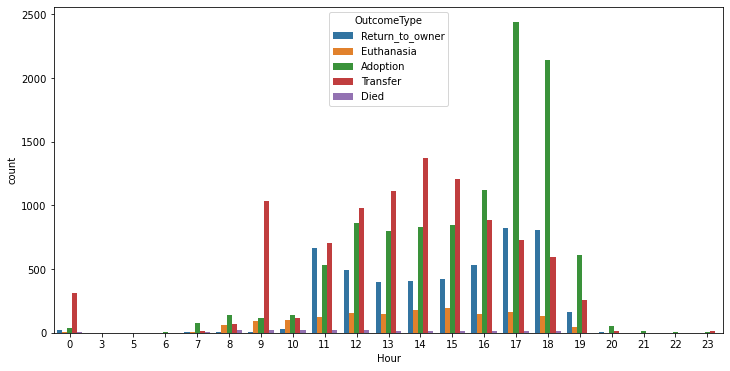

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12,6))
sns.countplot(all_data['Hour'], hue=all_data['OutcomeType']) #둘 다 문자일 때 countplot
#입양이 많은 시간 
#Transfer를 보내는 시간이 정해져있을 수 있음(자정, 오전9시)

### 분 별 Outcome 분포

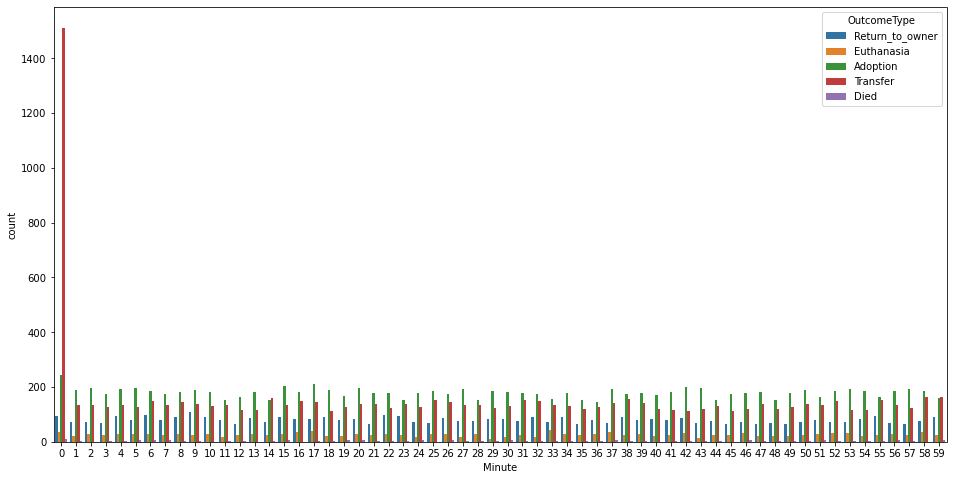

In [21]:
plt.figure(figsize=(16,8))
sns.countplot(all_data['Minute'],hue=all_data['OutcomeType'])
#모델이 '분'을 카테고리컬 형식으로 학습을 함 <- 특정 분에 따라서 변하게 
#categorical 느낌이 많은데 모델이 numerical로 학습하면 결과가 안좋아짐 >>> categorical로 인식하도록 명령해줘야 함

### 이름 유무별 Outcome 분포

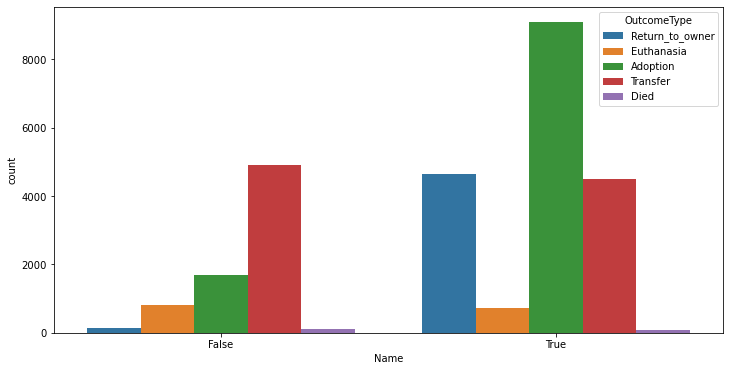

In [22]:
plt.figure(figsize=(12,6))
sns.countplot(all_data2['Name'], hue=all_data['OutcomeType'])

### AgeuponOutcome별 Outcome 분포- 특히 Adoption


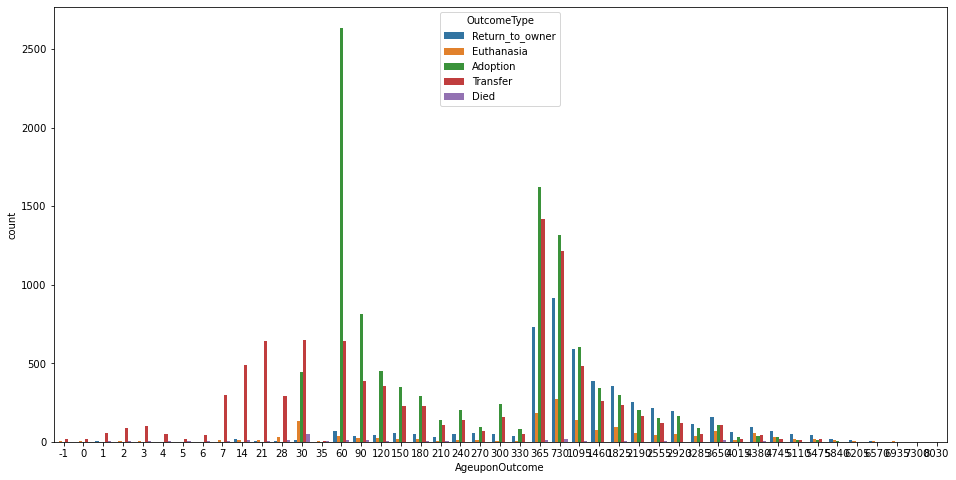

In [23]:
plt.figure(figsize=(16,8))
sns.countplot(all_data2['AgeuponOutcome'], hue=all_data['OutcomeType'])

## LabelEncoder 처리하여, Categorical변수 학습 가능하도록 만들기

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
c = all_data2.columns[all_data2.dtypes == object]
for i in c:
    all_data2[i] = le.fit_transform(list(all_data2[i])) #float: 결측치를 float으로 알아들음 -> *******결측치가 list를 만나면 string으로 받아들여짐 

In [25]:
all_data2 = all_data2.fillna(-1)

# 4.학습시키기 (Catboost)

In [26]:
train2 = all_data2[:len(train)]
test2 = all_data2[len(train):]

In [27]:
train2

,AnimalID,Name,AnimalType,SexuponOutcome,AgeuponOutcome,Year,Month,Day,Hour,Minute,...,0,1,2,3,4,5,6,7,8,9
0,5419,True,1,2,365,2014,2,12,18,22,...,0.607995,0.624923,0.096884,-0.036035,-0.423009,0.088759,-0.003331,-0.025158,-0.035768,-0.008018
1,1603,True,0,3,365,2013,10,13,12,44,...,0.084086,0.246263,-0.083321,0.008104,0.347898,-0.179452,0.000288,0.026855,-0.220526,0.054387
2,11613,True,1,2,730,2015,1,31,12,28,...,0.325392,0.144663,0.500209,-0.416300,0.341323,0.562517,-0.003951,-0.016572,0.048906,-0.006871
3,10238,False,0,1,21,2014,7,11,19,9,...,0.042119,0.063779,0.144587,-0.171586,0.342083,0.407422,-0.001043,0.018754,-0.064477,0.042204
4,3501,False,1,2,730,2013,11,15,12,52,...,0.129982,-0.058234,0.464935,0.858004,0.148937,0.068561,0.001577,0.005843,0.016420,0.000716
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26724,18631,False,0,1,30,2015,5,14,11,56,...,0.558533,0.781172,-0.047038,-0.007749,0.088234,-0.128393,-0.001538,0.000503,-0.153661,0.001077
26725,26055,False,0,3,90,2016,1,20,18,59,...,0.328748,0.797802,-0.365368,0.170854,0.213347,-0.031013,0.001489,0.030090,-0.137271,0.003050
26726,16731,True,1,2,1460,2015,3,9,13,33,...,0.403118,0.024119,0.710790,0.571486,0.017578,-0.050540,-0.001767,-0.023798,-0.019655,-0.001180
26727,7450,False,0,1,28,2014,4,27,12,22,...,0.709329,-0.533895,-0.428845,0.058984,0.138995,0.066862,-0.001910,0.014344,0.014511,0.001179


In [28]:
#GPU는 랜덤성이 있음 (시드값 줘도)
from catboost import CatBoostClassifier
cbc = CatBoostClassifier()
cbc.fit(train2, train['OutcomeType'], cat_features=[1,5,6])
result = cbc.predict_proba(test2)

Learning rate set to 0.093562
0:	learn: 1.4763326	total: 156ms	remaining: 2m 36s
1:	learn: 1.3755083	total: 249ms	remaining: 2m 4s
2:	learn: 1.2972606	total: 339ms	remaining: 1m 52s
3:	learn: 1.2336407	total: 437ms	remaining: 1m 48s
4:	learn: 1.1824557	total: 531ms	remaining: 1m 45s
5:	learn: 1.1363960	total: 613ms	remaining: 1m 41s
6:	learn: 1.0981451	total: 700ms	remaining: 1m 39s
7:	learn: 1.0672020	total: 788ms	remaining: 1m 37s
8:	learn: 1.0375454	total: 870ms	remaining: 1m 35s
9:	learn: 1.0135697	total: 988ms	remaining: 1m 37s
10:	learn: 0.9923763	total: 1.08s	remaining: 1m 36s
11:	learn: 0.9710427	total: 1.17s	remaining: 1m 35s
12:	learn: 0.9520842	total: 1.25s	remaining: 1m 35s
13:	learn: 0.9397018	total: 1.34s	remaining: 1m 34s
14:	learn: 0.9254643	total: 1.42s	remaining: 1m 33s
15:	learn: 0.9126141	total: 1.51s	remaining: 1m 32s
16:	learn: 0.9010800	total: 1.6s	remaining: 1m 32s
17:	learn: 0.8914732	total: 1.69s	remaining: 1m 32s
18:	learn: 0.8828321	total: 1.78s	remaining: 1

In [29]:
sub = pd.read_csv('/kaggle/input/shelter-animal-outcomes/sample_submission.csv.gz')

In [30]:
sub.iloc[:,1:] = result 

In [31]:
sub.to_csv('submission.csv', index=False)